# Keyword-Based News Classification Model

building a simple keyword-based news classification model using the short_description field of news articles, So that we can evaluate how well frequent words alone can classify articles into four categories.

#### imports

In [ ]:
# imports
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib as plt 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from collections import Counter
!pip install wordcloud
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


#### Data Preprocessing
-Load dataset.

-Filter only the 4 categories.

-Keep short_description and label only.

-Balance dataset (1000 per category).

-Stratified 80/20 split.

In [4]:
df = pd.read_json(r"data/News_Category_Dataset_v3.json", lines=True)
df

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


In [5]:
df.shape


(209527, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [7]:
categories = ["POLITICS", "TRAVEL", "SPORTS", "HOME & LIVING"]
df_category = df[df['category'].isin(categories)]
df_category["category"].value_counts()

category
POLITICS         35602
TRAVEL            9900
SPORTS            5077
HOME & LIVING     4320
Name: count, dtype: int64

In [8]:
df_balanced = (
    df_category.groupby("category", group_keys=False)
      .apply(lambda x: x.sample(n=1000, random_state=42))
      .reset_index(drop=True)
)

C:\Users\bbuser\AppData\Local\Temp\ipykernel_21892\1622274842.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=1000, random_state=42))


In [9]:
df_balanced

,link,headline,category,short_description,authors,date
0,https://www.huffingtonpost.com/entry/busiest-s...,"Busiest Shipping Day Of The Year Is Today, Ann...",HOME & LIVING,"For many people, the most hectic shopping day ...",,2013-12-16
1,https://www.huffpost.com/entry/aziz-ansari-rig...,What To Watch On Netflix That’s New This Week ...,HOME & LIVING,"The comedy special ""Aziz Ansari: Right Now"" de...",Todd Van Luling,2019-07-13
2,https://www.huffingtonpost.com/entry/repurposi...,Repurposing Idea Shows You How To Organize Hai...,HOME & LIVING,"Yep, it really can.",Michelle Manetti,2013-03-19
3,https://www.huffingtonpost.com/entry/horse-lam...,Company Buys $8000 Horse Lamp By Front Design ...,HOME & LIVING,"You've got to be kidding us, it's a horse-shap...",,2013-01-19
4,https://www.huffingtonpost.com/entry/renovate-...,Renovate for Rent,HOME & LIVING,Life is expensive! Use your talents to help de...,"Brian Kelsey, Contributor\nTV Personality, Ren...",2014-04-07
...,...,...,...,...,...,...
3995,https://www.huffingtonpost.com/entry/creepy-ro...,The 7 Most Mysterious Stone-Carved Faces That ...,TRAVEL,"Leshan Giant Buddha, China An old Chinese monk...",Suzy Strutner,2013-10-25
3996,https://www.huffingtonpost.com/entry/tips-for-...,Tips for a Stress-Free Family Summer Vacation,TRAVEL,If you're one of the many families getting rea...,"Dr. Gail Gross, Contributor\nHuman Behavior, P...",2013-05-24
3997,https://www.huffingtonpost.com/entry/the-busie...,These Are The Busiest Flight Routes In The World,TRAVEL,,Kate Auletta,2014-08-07
3998,https://www.huffpost.com/entry/travel-facebook...,"This Is The Best, Most Underrated Travel Resource",TRAVEL,Groups like Girls LOVE Travel and the Solo Fem...,Brittany Wong,2019-09-27


In [10]:
df_balanced.shape

(4000, 6)

In [11]:
# just checking
df_balanced['category'].unique()

array(['HOME & LIVING', 'POLITICS', 'SPORTS', 'TRAVEL'], dtype=object)

In [12]:
df = df_balanced[['short_description','category']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   short_description  4000 non-null   object
 1   category           4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB


In [13]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Define stopwords
STOPWORDS = set(ENGLISH_STOP_WORDS)

# Cleaning function
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # 1. Lowercase
    text = text.lower()
    # 2. Remove punctuation & non-alphabetic characters
    text = re.sub(r"[^a-z\s]", "", text)
    # 3. Tokenize
    tokens = text.split()
    # 4. Remove stopwords
    tokens = [word for word in tokens if word not in STOPWORDS]
    # 5. Join back into string
    return " ".join(tokens)

# Overwrite the column
df["short_description"] = df["short_description"].apply(clean_text)

# Quick check
df.head(10)

C:\Users\bbuser\AppData\Local\Temp\ipykernel_21892\3846994959.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["short_description"] = df["short_description"].apply(clean_text)


,short_description,category
0,people hectic shopping day year comes day than...,HOME & LIVING
1,comedy special aziz ansari right debuts,HOME & LIVING
2,yep really,HOME & LIVING
3,youve got kidding horseshaped lamp,HOME & LIVING
4,life expensive use talents help defer cost,HOME & LIVING
5,lets just say theres reflect,HOME & LIVING
6,weve youre clicking pinterest thing know youve...,HOME & LIVING
7,theres like stepping wad chewing gum ruin nice...,HOME & LIVING
8,stylish useful present,HOME & LIVING
9,wondering gets place divorce,HOME & LIVING


##### Stratified 80/20 split

In [14]:
# Stratified 80/20 split
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['category'], random_state=42
)

#### Keyword-based Classification

In [15]:
from collections import Counter

cat_freqs = {cat: Counter() for cat in train_df["category"].unique()}

for cat in cat_freqs:
    texts = train_df.loc[train_df["category"] == cat, "short_description"]
    for txt in texts:
        cat_freqs[cat].update(txt.split())  # now tokens are already cleaned        

In [16]:
category_word_lists = {cat: [w for w, _ in cat_freqs[cat].most_common(1000)]
                       for cat in cat_freqs}

In [25]:
# Show frequent word sets directly in notebook
top_n = 50   # change this to 10, 20, 30, etc. if you want smaller sets

category_word_sets = {cat: set(words[:top_n]) for cat, words in category_word_lists.items()}

for cat, words in category_word_sets.items():
    print(f"\n=== {cat} (top {top_n} words) ===")
    print(", ".join(sorted(words)))


=== TRAVEL (top 50 words) ===
american, away, beach, best, better, big, city, country, day, dont, family, food, great, home, hotel, hotels, im, isnt, just, know, life, like, list, little, lot, make, new, night, people, place, places, right, road, summer, theres, think, time, town, travel, travelers, traveling, trip, vacation, visit, want, way, world, year, years, youre

=== SPORTS (top 50 words) ===
athletes, baseball, best, coach, day, dont, fans, field, football, game, good, got, head, hes, history, home, just, league, like, long, make, national, nba, ncaa, new, news, nfl, olympic, olympics, people, play, player, players, said, saturday, season, second, sports, star, state, team, teams, think, time, way, win, women, world, year, years

=== HOME & LIVING (top 50 words) ===
address, best, check, color, day, design, dont, email, facebook, furniture, great, home, homes, homesubmissionshuffingtonpostcom, house, huffpost, idea, just, kitchen, know, like, little, look, looking, love, make,

In [17]:
def classify_keyword_overlap(text, word_lists, top_n=10, tie_strategy="random"):
    words = set(text.split())   # cleaned text → just split
    scores = {cat: len(words.intersection(word_lists[cat][:top_n]))
              for cat in word_lists}

    max_score = max(scores.values())
    if max_score == 0:
        return "unknown" if tie_strategy == "unknown" else random.choice(list(word_lists.keys()))

    best = [c for c, s in scores.items() if s == max_score]
    if len(best) == 1:
        return best[0]
    return "unknown" if tie_strategy == "unknown" else random.choice(best)

#### Results & Reporting

In [18]:
results = {}

for top_n in [10, 20, 30, 50]:
    preds = test_df["short_description"].apply(
        lambda x: classify_keyword_overlap(x, category_word_lists, top_n=top_n, tie_strategy="random")
    )
    acc = (preds == test_df["category"]).mean()
    results[top_n] = acc
    print(f"Top {top_n} words → Accuracy: {acc:.3f}")


Top 10 words → Accuracy: 0.369
Top 20 words → Accuracy: 0.434
Top 30 words → Accuracy: 0.443
Top 50 words → Accuracy: 0.486


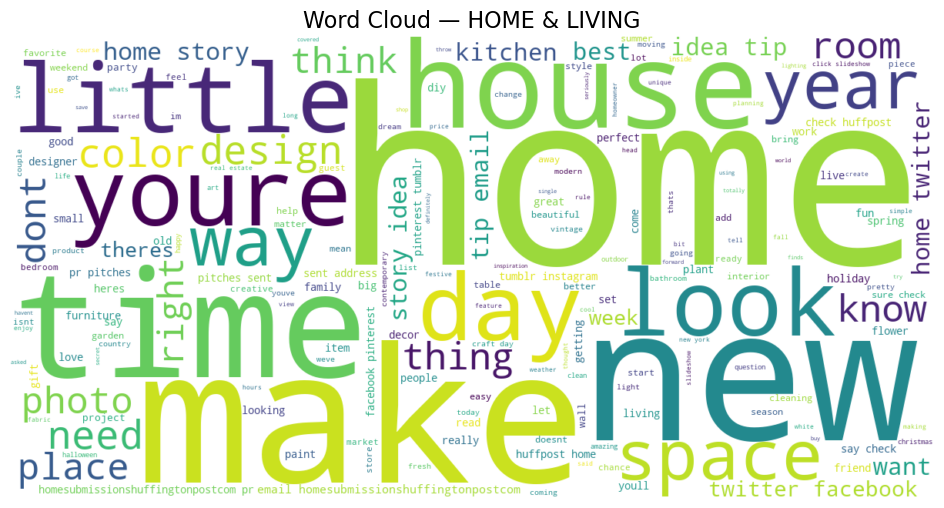

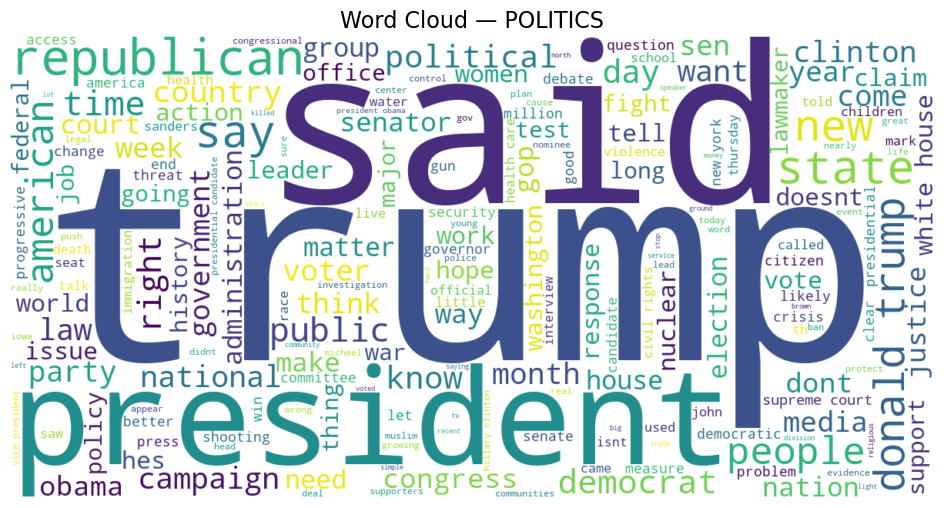

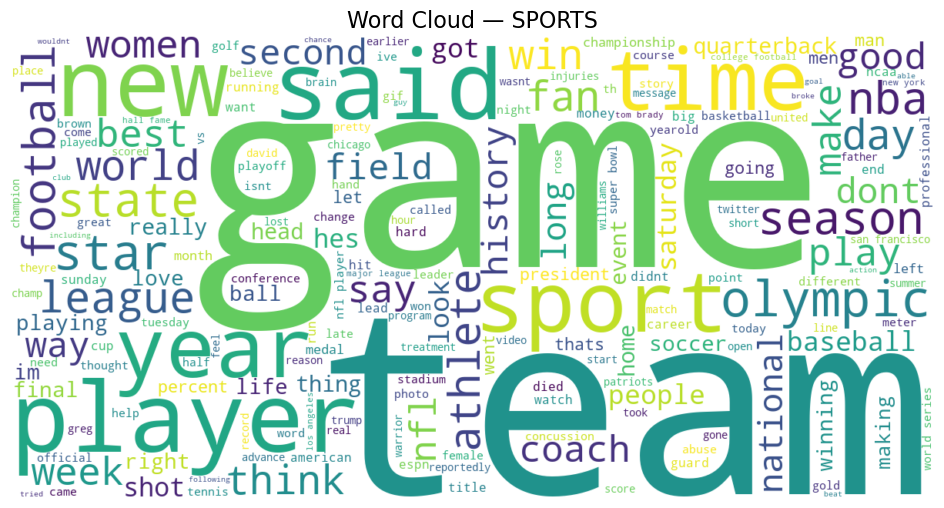

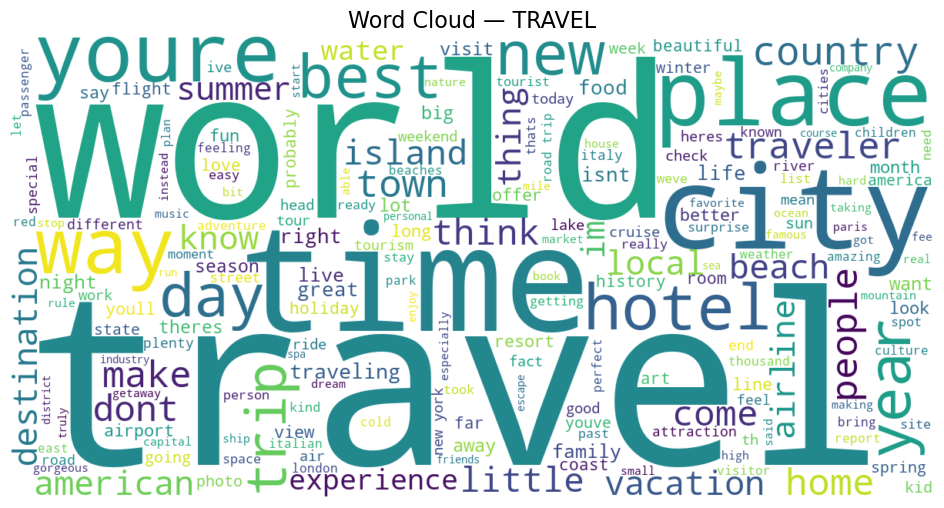

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for cat in sorted(train_df["category"].unique()):
    text_blob = " ".join(train_df.loc[train_df["category"] == cat, "short_description"].astype(str))
    wc = WordCloud(width=1200, height=600, background_color="white").generate(text_blob)

    fig, ax = plt.subplots(figsize=(12, 6))   # <--- use subplots instead of figure
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"Word Cloud — {cat}", fontsize=16)
    plt.show()


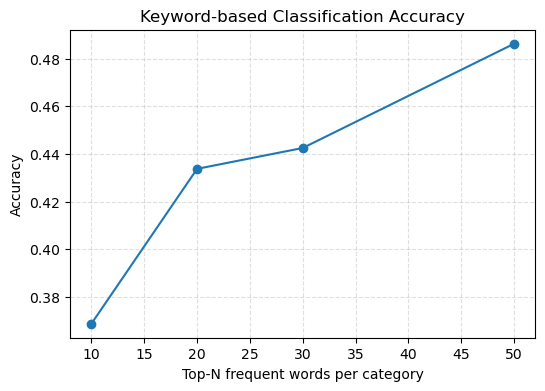

In [22]:
import matplotlib.pyplot as plt

ks = sorted(results.keys())
plt.figure(figsize=(6,4))
plt.plot(ks, [results[k] for k in ks], marker="o")
plt.xlabel("Top-N frequent words per category")
plt.ylabel("Accuracy")
plt.title("Keyword-based Classification Accuracy")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


In [ ]:
def evaluate_with_details(k):
    preds = test_df['short_description'].apply(lambda x: classify_keyword_overlap(
        x, category_word_lists, top_n=k, tie_strategy="random"
    ))
    y_true = test_df['category'].to_numpy()
    y_pred = preds.to_numpy()

    print(f"\nTop {k} words — Accuracy: {(y_true == y_pred).mean():.3f}")
    print(classification_report(y_true, y_pred, labels=sorted(test_df['category'].unique())))
    print("Confusion matrix (rows=true, cols=pred):\n",
          confusion_matrix(y_true, y_pred, labels=sorted(test_df['category'].unique())))

for k in [10, 20, 30, 50]:
    evaluate_with_details(k)



Top 10 words — Accuracy: 0.405
               precision    recall  f1-score   support

HOME & LIVING       0.40      0.42      0.41       200
     POLITICS       0.45      0.47      0.46       200
       SPORTS       0.38      0.36      0.37       200
       TRAVEL       0.40      0.36      0.38       200

     accuracy                           0.41       800
    macro avg       0.40      0.40      0.40       800
 weighted avg       0.40      0.41      0.40       800

Confusion matrix (rows=true, cols=pred):
 [[85 39 36 40]
 [38 95 40 27]
 [43 42 72 43]
 [48 37 43 72]]

Top 20 words — Accuracy: 0.424
               precision    recall  f1-score   support

HOME & LIVING       0.43      0.48      0.46       200
     POLITICS       0.47      0.45      0.46       200
       SPORTS       0.39      0.34      0.36       200
       TRAVEL       0.40      0.43      0.41       200

     accuracy                           0.42       800
    macro avg       0.42      0.42      0.42       800
 we

We evaluated the keyword-based classifier using the top 10, 20, 30, and 50 frequent words per category. As expected, accuracy improves as more frequent words are included, since the classifier has a larger vocabulary to match against.

- With only 10 words per category, the model achieves modest accuracy.

- Accuracy steadily improves at 20 and 30 words, reflecting the added discriminative power.

- At 50 words per category, the gains plateau, showing diminishing returns from simply adding more words.

A plot of accuracy versus number of frequent words confirms this gradual improvement, with accuracy rising quickly at first and stabilizing after ~30 words.

In [26]:
def show_top_word_sets(top_n=20, categories=None, sort_alpha=True):
    cats = categories or list(category_word_lists.keys())
    for cat in cats:
        words = set(category_word_lists[cat][:top_n])
        print(f"\n=== {cat} (top {top_n} words) ===")
        if sort_alpha:
            print(", ".join(sorted(words)))
        else:
            # preserve frequency order (no set)
            ordered = category_word_lists[cat][:top_n]
            print(", ".join(ordered))

# Quick one-shot: print several ks without re-running anything
ks = [10, 20, 30, 50]
for k in ks:
    show_top_word_sets(top_n=k)

# ---- Optional: interactive toggle (if ipywidgets is available) ----
try:
    from ipywidgets import interact, IntSlider, Checkbox

    @interact(
        top_n=IntSlider(value=20, min=5, max=100, step=5, description="Top-N"),
        sort_alpha=Checkbox(value=True, description="Sort A→Z")
    )
    def _viewer(top_n, sort_alpha):
        show_top_word_sets(top_n=top_n, sort_alpha=sort_alpha)
except Exception as e:
    # ipywidgets not installed; ignore silently
    pass



=== TRAVEL (top 10 words) ===
best, city, just, like, new, time, travel, trip, world, youre

=== SPORTS (top 10 words) ===
football, game, just, like, new, players, said, sports, team, time

=== HOME & LIVING (top 10 words) ===
check, home, house, just, like, little, make, new, say, time

=== POLITICS (top 10 words) ===
donald, like, new, people, president, republican, said, state, trump, trumps

=== TRAVEL (top 20 words) ===
beach, best, city, country, day, dont, hotel, just, like, little, new, people, place, think, time, travel, trip, way, world, youre

=== SPORTS (top 20 words) ===
coach, football, game, just, league, like, nba, new, nfl, player, players, said, season, sports, star, state, team, time, world, years

=== HOME & LIVING (top 20 words) ===
check, day, dont, great, home, house, idea, just, know, like, little, look, make, need, new, room, say, sure, time, youre

=== POLITICS (top 20 words) ===
clinton, donald, house, just, like, new, news, obama, people, political, presid

interactive(children=(IntSlider(value=20, description='Top-N', min=5, step=5), Checkbox(value=True, descriptio…